# Calibration resources that may be useful to the observer on duty

## Monitoring Calibration

The current calibration monitor points have not been integrated into influxdb and grafana.  You can check on the current status of calibration by pulling the relevant monitor points from etcd, shown below.

In [1]:
import dsautils.calstatus as cs
from dsautils.dsa_store import DsaStore
ETCD = DsaStore()

In [2]:
# Check the rsync queue.  This task rsyncs correlator output from the
# correlator machines to dsa-storage.
# All tasks should be alive (i.e. ntasks_alive == ntasks_total), and
# queue_size should not exceed 16 (the number of files for a single time,
# one generated on each correlator node).
print('rsync:', ETCD.get_dict('/mon/cal/rsync_process'))
print('')
# Check the freqeuncy integration.  This task removes the cable delays from the
# outrigger antennas before integrating in frequency by a factor of 8, down to
# 48 frequency channels per correlator node.  This acts on all 16 files for
# each time.  Again, all tasks should be alive (i.e. ntasks_alive ==
# ntasks_total), and queue_size should not exceed 16.
print('fscrunch:', ETCD.get_dict('/mon/cal/fscrunch_process'))
print('')
# Check the gathering task.  This task gathers the 16 files from the correlator
# machines for a single time. All tasks should be alive (i.e. ntasks_alive ==
# ntasks_total), and queue_size should not exceed 16. 
print('gather:', ETCD.get_dict('/mon/cal/gather_process'))
print('')
# Check the assessment queue.  This tasks checks to see if a calibrator exists
# in a given file.  It will only trigger calibration if the file contains the
# end of a 15-minute transit of the calibrator. All tasks should be alive
# (i.e. ntasks_alive == ntasks_total), and queue_size should not exceed a few.
print('assess:', ETCD.get_dict('/mon/cal/assess_process'))
print('')
# Check the calibration tasks.  This task does not run in a queue.  Instead, it
# is run by an etcd callback function that watches the /cmd/cal key.
# As a result, if multiple calls are made to /cmd/cal with the key 'calibrate'
# in short succession, multiple calibrations will be attempted simultaneous on
# the same python kernel.  This process only sends an alive signal with 60s
# cadence.
print('calibrate:', ETCD.get_dict('/mon/cal/calibrate_process'))
print('')
# Check the status of the most recent calibration. A status of -1 means that
# calibration is incomplete (perhaps in progress).  A non-negative status means
# that calibration is complete.  After calibration, plots are generated and 
# the calibration table in Grafana is updated.  The status can be decoded with
# the dsautils.calstatus.decode function.
print('most recent calibration:', ETCD.get_dict('/mon/cal/calibration'))
status = ETCD.get_dict('/mon/cal/calibration')['status']
if status > -1:
    print(cs.decode(status))

rsync: {'queue_size': 0, 'ntasks_alive': 1, 'ntasks_total': 1}

fscrunch: {'queue_size': 0, 'ntasks_alive': 1, 'ntasks_total': 1}

gather: {'queue_size': 0, 'ntasks_alive': 1, 'ntasks_total': 1}

assess: {'queue_size': 0, 'ntasks_alive': 1, 'ntasks_total': 1}

calibrate: {'alive': True, 'cadence': 60}

most recent calibration: {'transit_time': 59207.92317906705, 'calibration_source': 'J203147+545505', 'filelist': ['/mnt/data/dsa110/correlator/corr01/2020-12-24T22:06:52.hdf5', '/mnt/data/dsa110/correlator/corr02/2020-12-24T22:06:52.hdf5', '/mnt/data/dsa110/correlator/corr03/2020-12-24T22:06:52.hdf5', '/mnt/data/dsa110/correlator/corr21/2020-12-24T22:06:52.hdf5', '/mnt/data/dsa110/correlator/corr05/2020-12-24T22:06:52.hdf5', '/mnt/data/dsa110/correlator/corr06/2020-12-24T22:06:52.hdf5', '/mnt/data/dsa110/correlator/corr07/2020-12-24T22:06:52.hdf5', '/mnt/data/dsa110/correlator/corr08/2020-12-24T22:06:52.hdf5', '/mnt/data/dsa110/correlator/corr09/2020-12-24T22:06:52.hdf5', '/mnt/data/dsa1

## Coherence of solutions over time

In [3]:
import os
import numpy as np
from pkg_resources import resource_filename
import astropy.units as u
from dsacalib.calib import reset_flags, flag_baselines, flag_antenna
from casacore.tables import table
from dsacalib.routines import get_files_for_cal
import casatools as cc
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
antennas = np.concatenate((np.array(
    [24, 25, 26, 27, 28, 29, 30, 31, 32,
     33, 34, 35, 20, 19, 18, 17, 16, 15,
     14, 13, 100, 101, 102, 116, 103]),
    np.arange(36, 36+39)))

# Parameters that may need to be changed
date = '2020-12-18'
duration = 15*u.min # The length of the measurement set created, centered on the calibrator transit
refant = '102'

# Parameters that are mostly constant
calsources = resource_filename('dsacalib', 'data/calibrator_sources.csv')
refcorr = '01'
filelength = 15*u.min
msdir = '/mnt/data/dsa110/calibration/'
hdf5dir = '/mnt/data/dsa110/correlator/'
date_specifier = '{0}*'.format(date)

In [5]:
# Get a list of the files for each calibrator
filenames = get_files_for_cal(
    calsources,
    refcorr,
    duration,
    filelength,
    date_specifier=date_specifier,
    hdf5dir=hdf5dir
)
filenames_sorted = {k: filenames[date][k] for k in sorted(filenames[date].keys())}
filenames_sorted

{'J003101+540150': {'cal': <dsacalib.utils.src at 0x7f676366b518>,
  'transit_time': <Time object: scale='utc' format='isot' value=2020-12-18T02:35:28.579>,
  'files': ['2020-12-18T02:18:00', '2020-12-18T02:33:02']},
 'J004308+520334': {'cal': <dsacalib.utils.src at 0x7f676366b550>,
  'transit_time': <Time object: scale='utc' format='isot' value=2020-12-18T02:47:33.664>,
  'files': ['2020-12-18T02:33:02', '2020-12-18T02:48:04']},
 'J014829+533243': {'cal': <dsacalib.utils.src at 0x7f6763658908>,
  'transit_time': <Time object: scale='utc' format='isot' value=2020-12-18T03:52:43.848>,
  'files': ['2020-12-18T03:33:10', '2020-12-18T03:48:12']},
 'J022303+544849': {'cal': <dsacalib.utils.src at 0x7f676366ba90>,
  'transit_time': <Time object: scale='utc' format='isot' value=2020-12-18T04:27:11.935>,
  'files': ['2020-12-18T04:18:16', '2020-12-18T04:33:18']},
 'J032719+552029': {'cal': <dsacalib.utils.src at 0x7f676f7c1668>,
  'transit_time': <Time object: scale='utc' format='isot' value=2

In [ ]:
combine = 'field,scan,obs'
spwmap = [-1]
for cal in filenames_sorted.keys():
    msname = '{0}/{1}_{2}'.format(msdir, date, cal)
    if os.path.exists('{0}.ms'.format(msname)):
        reset_flags(msname)
        flag_baselines(msname, '2~27m')
        cb = cc.calibrater()
        cb.open('{0}.ms'.format(msname))
        cb.setsolve(
            type='B',
            combine=combine,
            table='{0}_{1}_bpcal'.format(msname, cal),
            refant=refant,
            apmode='p',
            t='inf'
        )
        cb.solve()
        cb.close()

In [ ]:
gains = [None]*len(filenames_sorted.keys())
gshape = None
for i, cal in enumerate(filenames_sorted.keys()):
    msname = '{0}/{1}_{2}'.format(msdir, date, cal)
    if os.path.exists('{0}_{1}_bpcal'.format(msname, cal)):
        with table('{0}_{1}_bpcal'.format(msname, cal)) as tb:
            gains[i] = np.array(tb.CPARAM[:])
        gshape = gains[i].shape
for i, g in enumerate(gains):
    if g is None:
        gains[i] = np.zeros(gshape, dtype=np.complex64)
gains = np.array(gains)

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(3*4, 3*5), sharex=True, sharey=True)
ax = ax.flatten()
for i in np.arange(20):
    ax[i].imshow(
        np.angle(gains[:, antennas[i]-1, :, 0]/gains[:, 23, :, 0]),
        vmin=-np.pi,
        vmax=np.pi,
        aspect='auto',
        origin='lower',
        interpolation='None',
        cmap=plt.get_cmap('RdBu')
    )
    ax[i].annotate('{0}'.format(antennas[i]), (0, 1), xycoords='axes fraction')
    ax[i].set_xlabel('Frequency channel')
    ax[i].set_ylabel('Calibrators')

## Manual Calibration - if calibration pipeline fails

This is an example of sending a calibration signal to the calibration pipeline if for some reason the pipeline fails and a source is not calibrated, or if you want to change, for e.g. the reference antenna or the duration of the transit that is calibrated to debug a failed calibration.  **Ideally, the observer on duty will not need to do this.**

In [12]:
import glob
import os
import numpy as np
from pkg_resources import resource_filename
import astropy.units as u
from dsacalib.plotting import summary_plot, plot_current_beamformer_solutions
from dsacalib.routines import get_files_for_cal, calibrate_measurement_set
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages

In [5]:
# Parameters that may need to be changed
date = '2020-12-11'
calname = 'J141120+521209'
duration = 15*u.min # The length of the measurement set created, centered on the calibrator transit
refant = '102'

# Parameters that are mostly constant
calsources = resource_filename('dsacalib', 'data/calibrator_sources.csv')
antennas = np.concatenate((np.array(
    [24, 25, 26, 27, 28, 29, 30, 31, 32,
     33, 34, 35, 20, 19, 18, 17, 16, 15,
     14, 13, 100, 101, 102, 116, 103]),
    np.arange(36, 36+39)))
refcorr = '01'
filelength = 15*u.min
msdir = '/mnt/data/dsa110/calibration/'
msname = '{0}/{1}_{2}'.format(msdir, date, calname)
date_specifier = '{0}*'.format(date)

In [9]:
# Get a list of the files for each calibrator
filenames = get_files_for_cal(
    calsources,
    refcorr,
    duration,
    filelength,
    date_specifier=date_specifier,
)
filenames[date][calname]

{'cal': <dsacalib.utils.src at 0x7ff553b992e8>,
 'transit_time': <Time object: scale='utc' format='isot' value=2020-12-11T16:41:04.522>,
 'files': ['2020-12-11T16:21:26', '2020-12-11T16:36:28']}

In [ ]:
flist = ['/mnt/data/dsa110/corr{0:02d}/{1}.hdf5'.format(corr, filenames[date][calname]['files'][-1]) for corr in 
        [1, 2, 3, 21, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]]

In [ ]:
# This is the command to start calibration, if the calibration process is running
# ETCD.put_dict(
#     '/cmd/cal',
#     {
#         'cmd': 'calibrate',
#         'val':
#         {
#             'calname': calname,
#             'flist': flist
#         }
#     }
# )

In [14]:
# You can also calibrate a measurement set using the python routine
status = calibrate_measurement_set(
    msname,
    filenames[date][calname]['cal'],
    refant='24',
    bad_antennas=None,
    bad_uvrange='2~27m',
    forsystemhealth=True
)

Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209.ms: 26 columns, 91000 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209.ms/FIELD: 9 columns, 1 rows
Successful read/write open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209.ms: 26 columns, 91000 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209_J141120+521209_2kcal: 13 columns, 1755 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209_J141120+521209_kcal: 13 columns, 117 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209_J141120+521209_2kcal: 13 columns, 1755 rows
Successful r

Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209_J141120+521209_2kcal: 13 columns, 1755 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209_J141120+521209_kcal: 13 columns, 117 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209_J141120+521209_bcal: 13 columns, 117 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209_J141120+521209_2gcal: 13 columns, 3276 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209.ms: 26 columns, 91000 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209.ms/SPECTRAL_WINDOW: 14 colu

/home/user/anaconda3/envs/casa/lib/python3.6/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209.ms: 26 columns, 91000 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209.ms/FIELD: 9 columns, 1 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209_J141120+521209_2kcal: 13 columns, 1755 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209_J141120+521209_kcal: 13 columns, 117 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209_J141120+521209_bcal: 13 columns, 117 rows
Successful readonly open of default-locked table /mnt/data/dsa110/calibration//2020-12-11_J141120+521209.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Succ

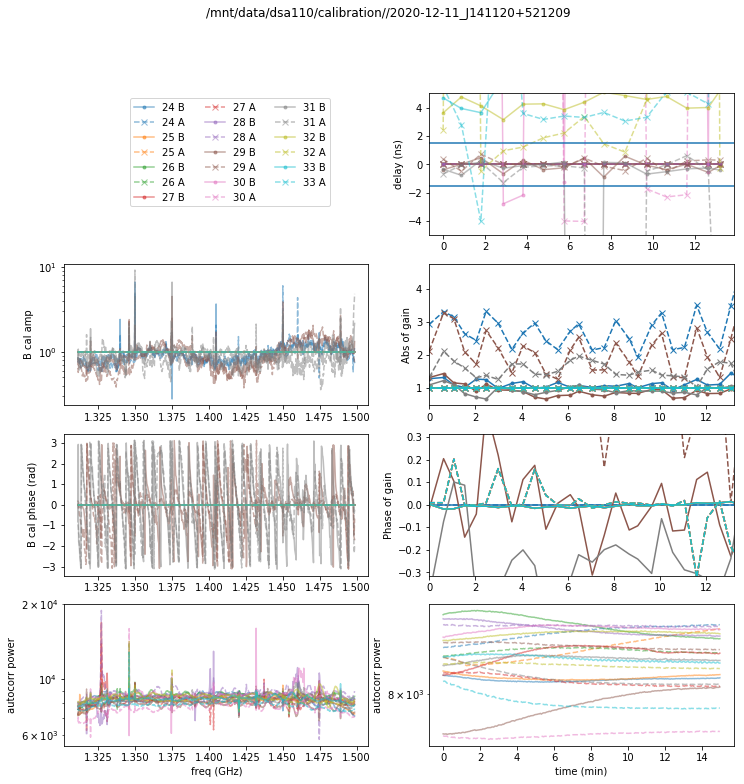

In [ ]:
# You can plot the summary plot in-line to examine
for j in range(len(antennas)//10+1):
    summary_plot(
        msname,
        calname,
        2,
        ['B', 'A'],
        antennas[j*10:(j+1)*10]
    )

In [ ]:
# You can also generate figures after the fact in the notebook
# For example - the beamformer solutions applied to the data:
plot_current_beamformer_solutions(
    filenames[date][calname]['files'],
    calname,
    date,
    corrlist=[1, 2, 3, 21, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
)